# Neural Text Generation with a Custom GPT

Author: [Ivan Bongiorni](https://github.com/IvanBongiorni) - 2023-02-05

In this tutorial I will implement a full **GPT** (Generative Pretrained Transformer). This model will be trained, *character by character*, on the complete works of Shakespeare. It will therefore generate *charachter embedding* representations. This will solve the problem of OOV (out-of-vocabulary) tokens.

In [1]:
import os

# disable annoying Nvidia warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import requests
import time
import re

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
INPUT_LENGTH = 128   # set length of text inputs for the model

Download the text dataset containing all Shakespeare's works:

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
page = requests.get(url)
text = page.text

Let's take a look at our corpus:

In [4]:
print(text[:147]) 

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?


Let's vectorize text, mapping every character into an integer to be fed into the Network. This can be done with a character-to-index dictionary:

In [5]:
# Store list of unique characters
unique_chars = list(set(text))
unique_chars.sort() 

# Map every letter in our alphabet to an int
char2idx = { char[1]: char[0] for char in enumerate(unique_chars) } 

# Produce a reverse dictionary to go back from int to str later
idx2char = { v: k for k, v in char2idx.items() } 

In [6]:
# Visualize length of our alphabet
print(len(char2idx)) 

65


In [7]:
print(char2idx) 

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


At this point, we are ready to vectorize all the corpus:

In [8]:
def numerical_encoding(text, char_dict):
    """
    First breaks text into a list of chars, then converts each to 
    its numerical idx (np.array) 
    """
    chars_list = [ char for char in text ]
    chars_list = [ char_dict[char] for char in chars_list ]
    chars_list = np.array(chars_list)
    return chars_list

In [9]:
encoded_text = numerical_encoding(text, char2idx) 

The next step is to process the vectorized text, creating sequences of length `INPUT_LENGTH`.

Given that a GPT is an autoregressive model developed for next-token prediction, you want to produce and input and a target sequence, where a target sequence corresponds to its input sequence but shifter forward of 1 step.

As an example, from the series of tokens:

```
A, B, C, D, E, F, G, H, I
```

Assuming an input length of size 4, we'd want to obtain:

```
 Input sequence:        Target sequence:
 A, B, C, D             B, C, D, E
 B, C, D, E             C, D, E, F
 C, D, E, F             D, E, F, G
 D, E, F, G             E, F, G, H
 E, F, G, H             F, G, H, I
```

In [10]:
def get_text_matrix(sequence, len_input):
    """
    This generates a matrix containing all the sequences
    of length INPUT_LENGTH to be fed into the Network
    """
    # create empty matrix
    X = np.empty((len(sequence)-len_input, len_input))
    
    # fill each row/time window from input sequence
    for i in range(X.shape[0]):
        X[i,:] = sequence[i : i+len_input]
        
    return X

In [11]:
X = get_text_matrix(encoded_text, INPUT_LENGTH+1) 
print(X.shape) 

(1115265, 129)


In [12]:
del encoded_text # free some memory

# Model Implementation

First, I will specify all the relevant hyperparameters and import the layer and model classes needed from `tensorflow` and `maximal`.

In [13]:
VOCAB_SIZE = len(char2idx) 
BATCH_SIZE = 64

N_EPOCHS = 3
LEARNING_RATE = 10e-5

N_LAYERS = 4
DEPTH = 256
HEADS = 4
FF_NODES = 256

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense

from exp import PositionalEmbedding, GPTLayer 

A Neural Network is a computational graph. I will start specifying its main elements.

A GPT doesn't work with traditional `Embedding()` layers but requires a `PositionalEmbedding()` from `maximal`. The representation generated by it will then be fed into a sequence of `GPTLayer`'s.

Finally, a simple `Dense()` layer will "guess", for each step of the sequence, what the next character is in the form of a probability distribution over the alphabet.

NB: Even though probability distributions are normally learned and produced via softmax gates, choosing the objective function as `sparse_categorical_crossentropy()` with the argument `from_logits=True` will take care of that, applying softmax under the hood.

In [15]:
# Input layer
input_batch = Input(shape=(INPUT_LENGTH,), dtype=tf.int32) 

# Positional Embedding
embedding = PositionalEmbedding(INPUT_LENGTH, VOCAB_SIZE, DEPTH) 

# List of GPT Layers
gpt_layers = [ GPTLayer(depth=DEPTH, heads=HEADS, ff_nodes=FF_NODES) for _ in range(N_LAYERS) ]

# Output layer
classification_layer = Dense(VOCAB_SIZE) 

Now we can build the computational graph by connecting all its elements together:

In [16]:
x = embedding(input_batch) 

for layer in gpt_layers:
    x = layer(x) 

classification = classification_layer(x) 

In [17]:
gpt = Model(
    inputs = input_batch,
    outputs = classification
) 

In [18]:
gpt.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 positional_embedding (Posit  (None, 128, 256)         49408     
 ionalEmbedding)                                                 
                                                                 
 gpt_layer (GPTLayer)        (None, 128, 256)          1184512   
                                                                 
 gpt_layer_1 (GPTLayer)      (None, 128, 256)          1184512   
                                                                 
 gpt_layer_2 (GPTLayer)      (None, 128, 256)          1184512   
                                                                 
 gpt_layer_3 (GPTLayer)      (None, 128, 256)          1184512   
                                                             

# Training with Custom Loops

In this tutorial, our GPT model is trained with custom training loop. The usual Keras pseudocode would be something such as: 

```
gpt.compile("adam", "sparse_categorical_crossentropy")
history = gpt.fit(X, Y, epochs)
```

but I will build custom training loops instead, to understand and have full control of the process.

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) 

I will wrap the training step into a function decorated with `@tf.function`. This will compile all steps into a single TensorFlow op, making it approximately an order of magnitude faster than plain Python.

In [20]:
@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        
        batch_loss = tf.reduce_sum(
            tf.keras.losses.sparse_categorical_crossentropy(
                y, gpt(x), 
                from_logits=True) 
        )
        
    gradients = tape.gradient(batch_loss, gpt.trainable_variables)
    optimizer.apply_gradients(zip(gradients, gpt.trainable_variables))
    return batch_loss

All is ready for training at this point. The main steps of the process are now:

0. At each epoch, reshuffle the dataset to add vary the composition of mini-batches.
0. For each iteration, extract a slice of the dataset of size `BATCH_SIZE`, and extract input and target arrays (x chars: `[0:128]`, y chars: `[1:129]`.
0. Run `train_step()` on input and target texts.
0. Periodically print Loss and store its value in `loss_history`

In [21]:
loss_history = [] 

for epoch in range(N_EPOCHS):
    start = time.time() 
    
    # Reshuffle data at each epoch to randomize mini-batch composition
    reshuffle = np.random.choice(X.shape[0], X.shape[0], replace=False) 
    X = X[reshuffle] 
    
    for iteration in range(X.shape[0] // BATCH_SIZE):
        
        # take new minibatch (with 1 char shift from x to y)
        take = iteration * BATCH_SIZE 
        x = X[ take:take+BATCH_SIZE , :-1 ]  # chars [0:128]
        y = X[ take:take+BATCH_SIZE , 1: ]   # chars [1:129]
        
        # training step
        current_loss = train_on_batch(x, y)
        
        # periodically store batch loss into history
        if iteration%100 == 0:
            loss_history.append(current_loss) 
            print(f"\t{iteration}\tLoss: {current_loss}") 
            
    print("{}.  \t  Loss: {}  \t  Time: {}ss".format(
        epoch+1, current_loss.numpy(), round(time.time()-start, 2))) 

	0	Loss: 40897.2421875
	100	Loss: 21843.64453125
	200	Loss: 20481.32421875
	300	Loss: 19570.765625
	400	Loss: 18836.8671875
	500	Loss: 17866.8671875
	600	Loss: 17402.84765625
	700	Loss: 16967.4375
	800	Loss: 16161.228515625
	900	Loss: 15842.638671875
	1000	Loss: 15614.90625
	1100	Loss: 15157.8916015625
	1200	Loss: 14976.1240234375
	1300	Loss: 14489.4404296875
	1400	Loss: 14479.0234375
	1500	Loss: 14091.2255859375
	1600	Loss: 13759.0078125
	1700	Loss: 13991.4697265625
	1800	Loss: 13952.77734375
	1900	Loss: 13135.15234375
	2000	Loss: 13449.2158203125
	2100	Loss: 13190.8115234375
	2200	Loss: 12990.8818359375
	2300	Loss: 13204.7333984375
	2400	Loss: 12758.6962890625
	2500	Loss: 12451.30078125
	2600	Loss: 12579.2685546875
	2700	Loss: 12112.064453125
	2800	Loss: 12417.76171875
	2900	Loss: 12481.78125
	3000	Loss: 12232.6396484375
	3100	Loss: 12005.94140625
	3200	Loss: 11975.517578125
	3300	Loss: 12250.564453125
	3400	Loss: 12110.6484375
	3500	Loss: 11863.5869140625
	3600	Loss: 11771.619140625

	12300	Loss: 7924.20849609375
	12400	Loss: 7896.609375
	12500	Loss: 7686.37109375
	12600	Loss: 7887.79296875
	12700	Loss: 7713.75634765625
	12800	Loss: 7597.95751953125
	12900	Loss: 7655.8955078125
	13000	Loss: 7591.650390625
	13100	Loss: 7591.33642578125
	13200	Loss: 7577.5654296875
	13300	Loss: 7626.443359375
	13400	Loss: 8031.3837890625
	13500	Loss: 7779.20703125
	13600	Loss: 7757.2724609375
	13700	Loss: 7749.1240234375
	13800	Loss: 7721.4921875
	13900	Loss: 7814.50048828125
	14000	Loss: 7703.8994140625
	14100	Loss: 7617.48828125
	14200	Loss: 7709.685546875
	14300	Loss: 7856.0771484375
	14400	Loss: 7710.79833984375
	14500	Loss: 7627.693359375
	14600	Loss: 7478.93994140625
	14700	Loss: 7420.509765625
	14800	Loss: 7478.00244140625
	14900	Loss: 7854.5146484375
	15000	Loss: 7710.85888671875
	15100	Loss: 7692.91796875
	15200	Loss: 7644.16796875
	15300	Loss: 7486.52734375
	15400	Loss: 7518.283203125
	15500	Loss: 7623.90966796875
	15600	Loss: 7545.5546875
	15700	Loss: 7617.244140625
	15800

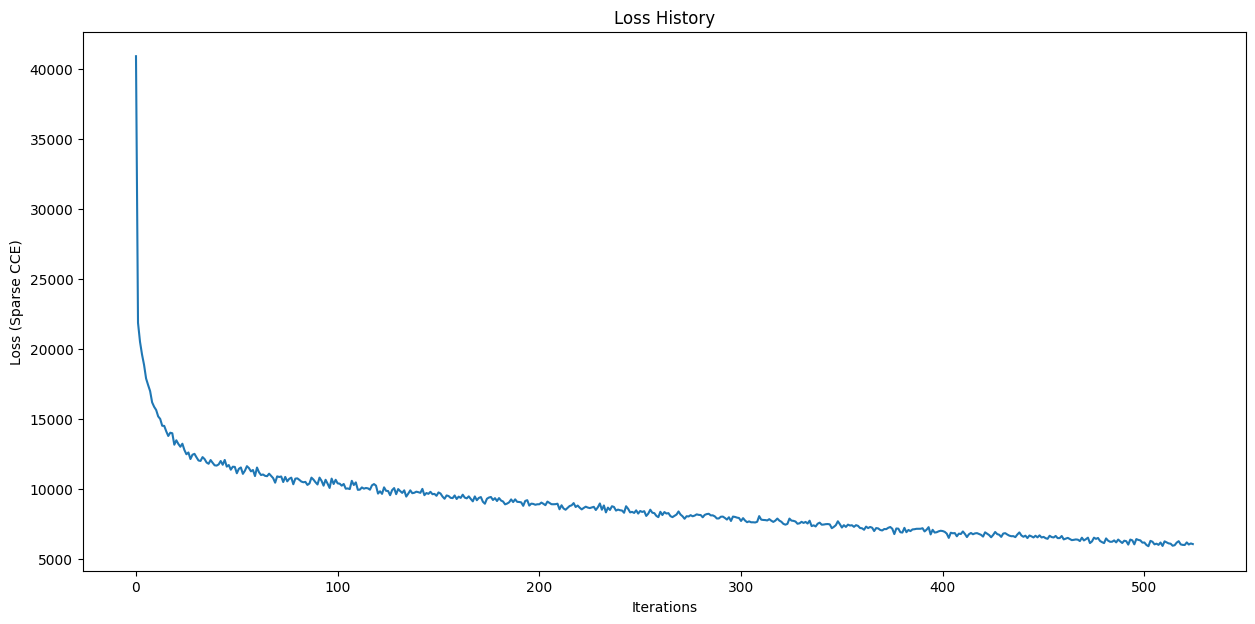

In [22]:
plt.figure(figsize=(15,7)) 
plt.plot(loss_history) 
plt.title('Loss History') 
plt.xlabel('Iterations')
plt.ylabel('Loss (Sparse CCE)')
plt.show() 

# Inference

At this point, the model is ready to generate new text. A specific function is needed for that, with the following arguments:
- A text `prompt` to start the generation.
- `n` number of tokens to be generated.
- A `temperature` parameter, governing the amount of noise in sampling the next token.
- A parameter that restrict sampling only to the top-`k` most likely tokens.

In [23]:
def generate_text(prompt, n=1000, temperature=1.0, k=10):
    """
    Inference time for the GPT.
    
    Args:
        prompt (str): input text
        n (int): number of tokens to be generated
        temperature (float): noise in the output probability
            (>1. = noisy sampling; <1. = conservative sampling.)
        k (int): restricts to number of top-k tokens to be sampled from
    """
    generated_text = []

    for i in tqdm(range(n)):
        #vectorize prompt and adjust np.array shape
        vectorized_text = [char2idx[c] for c in prompt] 
        vectorized_text = np.array(vectorized_text).reshape((1, len(vectorized_text)))
        
        # next token prediction 
        pred = gpt.predict(vectorized_text, verbose=0) 
        pred = np.squeeze(pred[:,-1,:]) 
        
        # temperature scaling
        pred /= temperature
        
        # restrict sampling to top k tokens
        probs, indices = tf.math.top_k(pred, k, sorted=True) 
        
        # sample token id
        probs = tf.nn.softmax(probs).numpy() 
        pred_id = np.random.choice(indices, p=probs) 
        
        # update prompt
        next_char = idx2char[pred_id] 
        prompt = prompt[1:] + next_char
        generated_text.append(next_char)
        
    generated_text = ''.join(generated_text)
    return generated_text 

I will now feed a piece of the famous Hamlet's monologue to the GPT and ask it to continue from it:

In [24]:
prompt = """To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune"""

In [25]:
generation = generate_text(prompt=prompt, n=500, temperature=0.2) 

100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 20.98it/s]


In [26]:
print(generation) 

 me,
And there is all the sister of my love:
I am your good falcon doth limit cut off one so much.

ANGELO:

ISABELLA:
And so doth the end of men's enemies.

CLARENCE:
A joyful day day, and bunk with the crown,
And then, with a light of usurning those you speak to the crown,
And then, all the sun sets, which is the matter,
That we may be another than the witness of her is
An honourable and shrewd my lord.

DUKE OF YORK:
Art thou shalt be satisfied?

RICHARD:
I'll beat the consul! What think'st t


In [30]:
generation = generate_text(prompt=prompt, n=1000, temperature=0.2, k=10) 

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.21it/s]


In [31]:
print(generation) 

 so fast.

PETRUCHIO:
Why, sir, in me in this castle:
I have hold to me a mind,
And say 'Alas, thou shalt to make thee no suglen.' Where is my page!
And bay I had, to make thee thus farewly no further.

PETRUCHIO:
Why, sir, if nothing else, brine come to your pleasure hath.

KATHARINA:
I pray you, sir, they say, it werlik,
cannot of the sun upon his court him and her head.

PETRUCHIO:
Why, she hath such pity time would.

HORTENSIO:
Sir, induced in his power!
What says he? the borrow of his law garments and why he?

BUCKINGHAM:
No, so I to temptest, my lords,
You scarce them and my gracious lord,
Than they brided on the children of hell.

GLOUCESTER:
I did not kill the truth of my love:
I am the survive intelligences of your daughter's son,
And then to all the world at the faults
At my master gentle, and their chains of straight:
We have not without the wars of conscience and so made
That's such appetite words draw the fart.

LEONTES:
What with him?

PAULINA:
These testimony many mouth


In [29]:
gpt.save('gpt_shakespeare_14.h5') 